In [1]:
import pandas as pd
from tqdm import tqdm
from FlagEmbedding import FlagModel
from opensearchpy import OpenSearch

df_evaluation = pd.read_csv('evaluation.csv')
data_list = df_evaluation.values.tolist()

mrr_sum = 0

index_name = 'abstracts_bge'

model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="Represent this sentence for searching relevant passages:",
                  use_fp16=False)

client = OpenSearch(
    hosts=[{"host": 'opensearch', "port": 9200}],
    http_auth=('admin', 'admin'),
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False,
)

for query, _, correct_pmid in tqdm(data_list):
    embedding = model.encode_queries(query).tolist()
    body = {
        "size": 5,
        "query": {
            "script_score": {
                "query": {
                    "match_all": {}
                },
                "script": {
                    "source": "knn_score",
                    "lang": "knn",
                    "params": {
                        "field": "vector",
                        "query_value": embedding,
                        "space_type": "cosinesimil"
                    }   
                }
            }
        }
    }
    res = client.search(index=index_name, body=body)
    search_results_pmids = [hit['_source']['pmid'] for hit in res['hits']['hits']]
    if correct_pmid in search_results_pmids:
        rank = search_results_pmids.index(correct_pmid) + 1
        mrr_sum += 1 / rank

mrr = mrr_sum / len(data_list)
print(f"Mean Reciprocal Rank (MRR): {mrr}")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.73it/s]

Mean Reciprocal Rank (MRR): 0.7259333333333335


In [6]:
import pandas as pd
from tqdm import tqdm
from FlagEmbedding import FlagModel
from opensearchpy import OpenSearch

df_evaluation = pd.read_csv('evaluation.csv')
data_list = df_evaluation.values.tolist()

mrr_sum = 0

index_name = 'abstracts_bge_fin1'

model = FlagModel('bge_large_fin', 
                  query_instruction_for_retrieval="Represent this sentence for searching relevant passages:",
                  use_fp16=False)

client = OpenSearch(
    hosts=[{"host": 'opensearch', "port": 9200}],
    http_auth=('admin', 'admin'),
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False,
)

for query, _, correct_pmid in tqdm(data_list):
    embedding = model.encode_queries(query).tolist()
    body = {
        "size": 5,
        "query": {
            "script_score": {
                "query": {
                    "match_all": {}
                },
                "script": {
                    "source": "knn_score",
                    "lang": "knn",
                    "params": {
                        "field": "vector",
                        "query_value": embedding,
                        "space_type": "cosinesimil"
                    }   
                }
            }
        }
    }
    res = client.search(index=index_name, body=body)
    search_results_pmids = [hit['_source']['pmid'] for hit in res['hits']['hits']]
    if correct_pmid in search_results_pmids:
        rank = search_results_pmids.index(correct_pmid) + 1
        mrr_sum += 1 / rank

mrr = mrr_sum / len(data_list)
print(f"Mean Reciprocal Rank (MRR): {mrr}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:15<00:00,  2.02it/s]

Mean Reciprocal Rank (MRR): 0.7960666666666668


In [18]:

from transformers import BertForSequenceClassification
import torch
from transformers import BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BERTMultiLabelBinaryClassification_FactorLoss(torch.nn.Module):
    def __init__(self, num_labels, label_weight, gamma=2.0, mix_ratio=0.5):
        super(BERTMultiLabelBinaryClassification_FactorLoss, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.label_weight = torch.tensor(label_weight)
        self.gamma = gamma
        self.mixed_loss = MixedLoss(weight=self.label_weight, gamma=self.gamma, pos_weight=self.label_weight,
                                    mix_ratio=mix_ratio).to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            loss = self.mixed_loss(logits.view(-1, self.bert.config.num_labels),
                                   labels.view(-1, self.bert.config.num_labels))
            return loss
        else:
            return logits


class BERTMultiLabelBinaryClassification(torch.nn.Module):
    def __init__(self, num_labels, label_weight):
        super(BERTMultiLabelBinaryClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.label_weight = label_weight

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        if labels is not None:
            pos_weight = torch.tensor(self.label_weight)
            pos_weight.to(device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            loss_fct.to(device)
            loss = loss_fct(logits.view(-1, self.bert.config.num_labels), labels.view(-1, self.bert.config.num_labels))
            return loss
        else:
            return logits

from transformers import BertForSequenceClassification
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MixedLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, pos_weight=None, mix_ratio=0.5):
        super(MixedLoss, self).__init__()
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma, reduction="mean").to(device)
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        self.mix_ratio = mix_ratio

    def forward(self, inputs, targets):
        loss_focal = self.focal_loss(inputs, targets)
        loss_bce = self.bce_loss(inputs, targets)
        return (self.mix_ratio * loss_focal) + ((1 - self.mix_ratio) * loss_bce)


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='none'):
        super(FocalLoss, self).__init__()
        self.weight = weight.to(device)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_loss = BCE_loss.to(device)
        pt = torch.exp(-BCE_loss)
        F_loss = self.weight * ((1 - pt) ** self.gamma) * BCE_loss

        if self.reduction == 'sum':
            return torch.sum(F_loss)
        elif self.reduction == 'mean':
            return torch.mean(F_loss)
        else:
            return F_loss


TYPE = ['Confirmation Questions', 'Factoid-type Questions', 'List-type Questions', 'Causal Questions',
        'Hypothetical Questions', 'Complex Questions']

load_model_name = "./model_state_dict_all_data_1.pth"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTMultiLabelBinaryClassification_FactorLoss(num_labels=6, gamma=2.5,
                                                        mix_ratio=0.3, label_weight=[0, 0, 0, 0, 0, 0])
model.load_state_dict(torch.load(load_model_name, map_location=device))

def classify(question):
    sentence_encodings = tokenizer(question, truncation=True, padding=True, max_length=128)
    sentence_seq = torch.tensor(sentence_encodings['input_ids'])
    sentence_mask = torch.tensor(sentence_encodings['attention_mask'])
    model.eval()
    with torch.no_grad():
        model.cpu()
        inputs = {
            'input_ids': sentence_seq.unsqueeze(0),
            'attention_mask': sentence_mask.unsqueeze(0)
        }
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs).detach().cpu().numpy()

    pred_labels = (logits > 0.5).astype(int)
    return pred_labels[0]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('evaluation.csv')

# 创建一个字典，用于存储每种类型的问题
questions_by_type = {type_name: pd.DataFrame(columns=df.columns) for type_name in TYPE}

# 对每个问题进行分类，并将结果保存到对应的字典条目中
for index, row in df.iterrows():
    classification = classify(row['Question'])
    for i, class_type in enumerate(classification):
        if class_type == 1:
            # 如果问题属于当前类型，将整行数据添加到对应的类型DataFrame中
            questions_by_type[TYPE[i]] = pd.concat([questions_by_type[TYPE[i]], pd.DataFrame([row])], ignore_index=True)

# 为每种类型保存一个新的CSV文件
for type_name, questions_df in questions_by_type.items():
    if not questions_df.empty:
        questions_df.to_csv(f'{type_name}.csv', index=False)

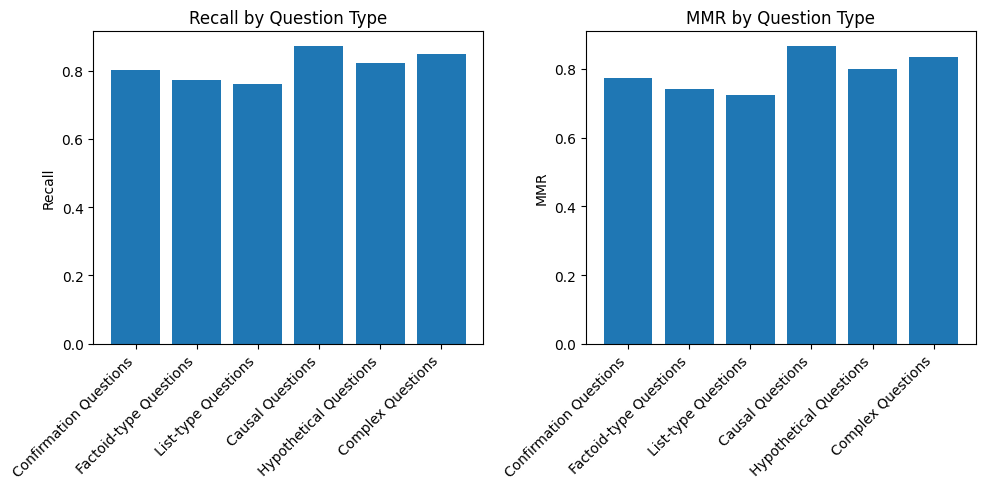

In [1]:
import pandas as pd
from pinecone import Pinecone
from FlagEmbedding import FlagModel
import matplotlib.pyplot as plt

model = FlagModel('bge_large_fin', 
                  query_instruction_for_retrieval="Represent this sentence for searching relevant passages:",
                  use_fp16=True)

pc = Pinecone(api_key="621f7574-8c97-4f46-8c5e-186dd099d33b")
index = pc.Index("bge-fin")

# 假设有一个函数或数据结构来获取与每个问题相关的pmid列表
def get_relevant_pmids(question):
    # 返回与问题相关的pmid列表
    query_vector = model.encode_queries([question])[0].tolist()
    
    response = index.query(
        vector=query_vector,
        top_k=3,
        include_metadata=True  
    )

    pmids = [match['metadata']['pmid'] for match in response['matches']]

    return pmids

# 定义问题类型
TYPE = [
    'Confirmation Questions', 
    'Factoid-type Questions', 
    'List-type Questions', 
    'Causal Questions',
    'Hypothetical Questions', 
    'Complex Questions'
]

# 存储每种类型的召回率和MMR
recall_by_type = {}
mmr_by_type = {}

for type_name in TYPE:
    # 读取对应类型的CSV文件
    df = pd.read_csv(f'{type_name}.csv')
    recalls = []
    mmrs = []
    
    for i, row in df.iterrows():
        relevant_pmids = get_relevant_pmids(row['Question'])
        original_pmid = str(row['PMID'])  # 确保PMID的格式与get_relevant_pmids返回的一致
        
        # 计算召回率
        recall = 1 if original_pmid in relevant_pmids else 0
        recalls.append(recall)
        
        # 计算MMR
        if original_pmid in relevant_pmids:
            rank = relevant_pmids.index(original_pmid) + 1
            mmr = 1 / rank
        else:
            mmr = 0
        mmrs.append(mmr)
    
    # 计算平均召回率和MMR
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_mmr = sum(mmrs) / len(mmrs) if mmrs else 0
    
    recall_by_type[type_name] = avg_recall
    mmr_by_type[type_name] = avg_mmr

# 可视化召回率和MMR
plt.figure(figsize=(10, 5))

# 绘制召回率
plt.subplot(1, 2, 1)
plt.bar(range(len(recall_by_type)), list(recall_by_type.values()), tick_label=list(recall_by_type.keys()))
plt.xticks(rotation=45, ha='right')
plt.title('Recall by Question Type')
plt.ylabel('Recall')

# 绘制MMR
plt.subplot(1, 2, 2)
plt.bar(range(len(mmr_by_type)), list(mmr_by_type.values()), tick_label=list(mmr_by_type.keys()))
plt.xticks(rotation=45, ha='right')
plt.title('MMR by Question Type')
plt.ylabel('MMR')

plt.tight_layout()
plt.show()


In [ ]:
import json

with open('recall_by_type_3.json', 'w') as fp:
    json.dump(recall_by_type, fp)

with open('mmr_by_type_3.json', 'w') as fp:
    json.dump(mmr_by_type, fp)